In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

# <font face="gotham" color="purple">What Is Qualitative Response Model?</font>

So far we have only discussed the model that takes $Y$ as a quantitative variable by default, however there are situations we want $Y$ to be qualitative variable, for example, $Y = 1$ represents a family owns house, $Y=0$ means not owning a flat, independent variables can be quantitative variables such as their income, ages, education and etc.

Specifically, if the response variables only takes two values, such as $1$ or $0$, we call them **binary variable**, the regression model with binary variable as dependent variable is called **binary response regression model**, similarly there is also **trichotomous response regression model** or more generally **polychotomous response regression model**, but names do not matter, they are all **qualitative response model** as in the question of this section.

For easy demonstration, we will mostly deal with _binary response model_, there are four approaches to develop this type of model: **linear probability model**, **logit model**, **probit model** and **tobit model**. 

We will go through all of them in this chapter.

# <font face="gotham" color="purple">The Linear Probability Model (LPM)</font>

Consider a simple regression model
$$
Y_{i}=\beta_{1}+\beta_{2} X_{i}+u_{i}
$$
where $X$ represents family income, $Y=1$ represents if the family owns a flat and $0$ the opposite. There are only two outcomes, either own a flat or not, so $Y_i$ follows **Bernoulli Distribution**.

It would be fast to recognize the $u_i$ can't be normally distributed, since
$$
u_{i}=Y_{i}-\beta_{1}-\beta_{2} X_{i}
$$
If we denote the probability $Y_i=1$ as $P_i$ and $Y_i=0$ as $1-P_i$, then
$$
\begin{array}{lcc} 
& u_{i} & \text { Probability } \\
\text { When } Y_{i}=1 & 1-\beta_{1}-\beta_{2} X_{i} & P_{i} \\
\text { When } Y_{i}=0 & -\beta_{1}-\beta_{2} X_{i} & \left(1-P_{i}\right)
\end{array}
$$
it shows that $u_i$ also follows Bernoulli distribution.

Recall the fact from statistics course, that the variance of Bernoulli distribution is $P_i(1-P_i)$, what's more
$$
E\left(Y_{i} \mid X_{i}\right)=\beta_{1}+\beta_{2} X_{i}=0\left(1-P_{i}\right)+1\left(P_{i}\right)=P_{i}
$$
The $P_i$ is a function of $X_i$, hence $u_i$ is heteroskedastic. 

## <font face="gotham" color="purple">Home Owners' Example</font>

Here is an excerpt data from a real estate survey in Manchester, UK. The family income is measured in thousand pounds.

In [84]:
df = pd.read_excel('Basic_Econometrics_practice_data.xlsx', sheet_name = 'HouseOwn_Quali_Resp'); df.head()

,Annual_Family_Income,Own_House
0,56,1
1,78,1
2,67,0
3,34,1
4,23,0


Perform a quick OLS estimation (ignoring the heteroskedasticity for now) and plot the regression line.

In [85]:
X = df['Annual_Family_Income']
Y = df['Own_House']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit() 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              Own_House   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     50.32
Date:                Thu, 02 Sep 2021   Prob (F-statistic):           2.47e-08
Time:                        14:34:24   Log-Likelihood:                -10.752
No. Observations:                  38   AIC:                             25.50
Df Residuals:                      36   BIC:                             28.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1981 

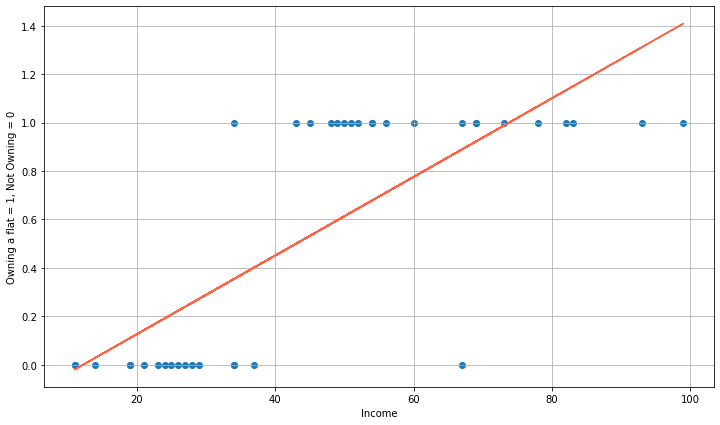

In [86]:
fig, ax = plt.subplots(figsize = (12, 7))
ax.scatter(df['Annual_Family_Income'], df['Own_House'])
ax.plot(df['Annual_Family_Income'], model.fittedvalues, color = 'tomato')
ax.grid()
ax.set_xlabel('Income')
ax.set_ylabel('Owning a flat = 1, Not Owning = 0')
plt.show()

Let's interpret the results, the constant term is $-0.1981$, but probability can never be negative, hence we ignore constant term, or simply treat it as $0$. The slope term $0.0162$ indicates that in average with every $1000$ pounds increment in family income, the probability of owning a house will increase $1.6\%$.

However, you could doubt its reliability that assuming income and probability is linear relation, actually it's more rational to assume there is some threshold to afford a house, if the house cost $500000$ pounds, earning $20000$ shouldn't be any obvious improvement than earning $10000$. Similarly, family with income of $200000$ wouldn't be much different than family with income of $190000$. We will talk about how to model this assumption in next section. So far we will stick with LPM.

What if a family has $39000$ pounds of annual income? Our model predicts the probability they own a house is $-0.1981 + 39\times0.0162=.43$. But how about family income of $11000$ pounds? The models says $-0.1981 + 11\times0.0162=-0.0199$, it predicts a negative probability and apparent it has no sense. Similarly, if a family has $99000$ pounds income, the model predicts a probability $-0.1981 + 99\times0.0162=1.4057$ which is more than $1$.

If the vertical axis represents probabilities, i.e. $0 \leq E\left(Y_{i} \mid X_{i}\right) \leq 1 $, it would be a natural defects of LPM to predict out of this range.

However, we still haven't address the heteroskedasticity issue of LPM, which means the estimated results above are actually all _invalid_! For fast remedy, you can invoke the White's robust standard error.

In [87]:
model.HC0_se

const                   0.086859
Annual_Family_Income    0.001809
dtype: float64

To handle the issue more seriously, we use WLS to obtain more efficient estimates. Because variance of disturbance term is 
$$
\operatorname{var}\left(u_{i}\right)=P_{i}\left(1-P_{i}\right)=\sqrt{E\left(Y_{i} \mid X_{i}\right)\left[1-E\left(Y_{i} \mid X_{i}\right)\right]}
$$
So we estimate the disturbance term by using fitted values, note that these are different than residuals!
$$
w_i=\hat{Y}_{i}\left(1-\hat{Y}_{i}\right)
$$

Add fitted value into the data frame.

In [71]:
df['fitted_value'] = model.fittedvalues
df.head()

,Annual_Family_Income,Own_House,fitted_value
0,56,1,0.710644
1,78,1,1.067667
2,67,0,0.889155
3,34,1,0.353621
4,23,0,0.175110


Exclude all values out of probabilistic range, then calculate the weight.

In [74]:
df = df[df['fitted_value']>0]
df = df[df['fitted_value']<1]
df['weight'] = np.sqrt(df['fitted_value']*(1-df['fitted_value']))

In [76]:
df.head()

,Annual_Family_Income,Own_House,fitted_value,weight
0,56,1,0.710644,0.453463
2,67,0,0.889155,0.313940
3,34,1,0.353621,0.478093
4,23,0,0.175110,0.380061
5,19,0,0.110197,0.313135


Divide weight onto every terms in the model
$$
\frac{Y_{i}}{\sqrt{w_{i}}}=\frac{\beta_{1}}{\sqrt{w_{i}}}+\beta_{2} \frac{X_{i}}{\sqrt{w_{i}}}+\frac{u_{i}}{\sqrt{w_{i}}}
$$

In [77]:
df['Annual_Family_Income_WLS'] = df['Annual_Family_Income']/df['weight']
df['Own_House_WLS'] = df['Own_House']/df['weight']

Here's the more reliable result.

In [78]:
X = df['Annual_Family_Income_WLS']
Y = df['Own_House_WLS']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit() 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:          Own_House_WLS   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     94.47
Date:                Thu, 02 Sep 2021   Prob (F-statistic):           1.25e-10
Time:                        14:17:57   Log-Likelihood:                -40.040
No. Observations:                  31   AIC:                             84.08
Df Residuals:                      29   BIC:                             86.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

The slope estimates of WLS is similar but higher significance due to smaller standard error and $R^2$ also much higher than previous model.

Though we have fixed heteroskedasticity to some extent, the model is not attractive in either breaking probabilistic range or its unrealistic linear shape. In Next section we will discuss about alternatives to LPM that fulfill both probabilistic range and nonlinear shape.

# <font face="gotham" color="purple"> The Logit Model</font>

The **logit model** hypothesizes a sigmoid shape function 
$$
P_i = \frac{1}{1+e^{-(\beta_1+\beta_2X_i)}}
$$

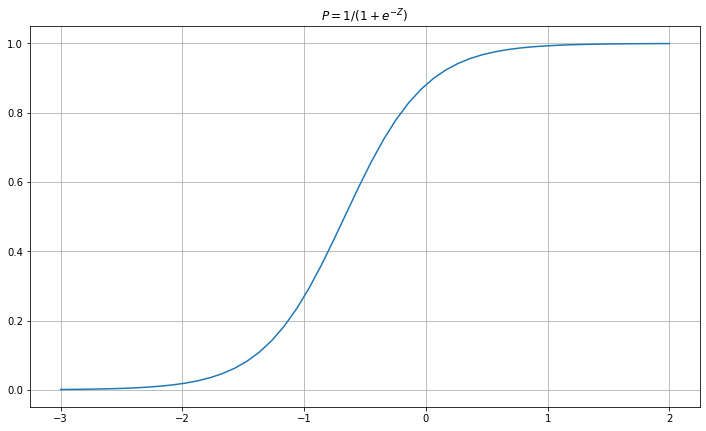

In [5]:
beta1, beta2 = 2, 3
X = np.linspace(-3, 2)
P = 1/(1 + np.exp(-beta1-beta2*X))
fig, ax = plt.subplots(figsize = (12, 7))
ax.plot(X, P)
ax.set_title(r'$P = 1/(1+e^{-Z})$')
ax.grid()

We usually denote $Z_i = \beta_1+\beta_2X_i$, ranges from $(-\infty, +\infty) $. This model solves the issues of probabilistic range and linear model. 

In order to estimate the logit model, we are seeking ways to linearize it. It might look confusing at first sight, here is the steps
$$
P_{i}=\frac{1}{1+e^{-Z_{i}}}=\frac{e^{Z_i}}{e^{Z_i}}\frac{1}{1+\frac{1}{e^{Z_i}}}=\frac{e^{Z_i}}{1+e^{Z}}
$$

And $1-P_i$
$$
1-P_{i}=\frac{1}{1+e^{Z_{i}}}
$$

Combine them, we have the odds ratios
$$
\frac{P_{i}}{1-P_{i}}=\frac{1+e^{Z_{i}}}{1+e^{-Z_{i}}}=e^{Z_{i}}
$$

Here's the interesting part, take natural log, we get a linearized model and we commonly call the log odds ratios the **logit**.
$$
\underbrace{\ln{\bigg(\frac{P_{i}}{1-P_{i}}\bigg)}}_{\text{logit}}= Z_i =\beta_1+\beta_2X_i
$$

To estimate the model, some technical procedures have to be carried out, because logit wouldn't make any sense, if we simply plug in the data $Y_i$, because we don't observe $P_i$, the results are nonsensical.
$$
\ln \left(\frac{1}{0}\right) \quad \text{if a family own a house}\\
\ln \left(\frac{0}{1}\right) \quad \text{if a family does not own a house}
$$

One way to circumvent this technical issue, the data can be grouped to compute
$$
\hat{P}_{i}=\frac{n_{i}}{N_{i}}
$$
where $N_i$ is number of families in a certain income level, e.g. $[20000, 29999]$, and $n_i$ is the number of family owning a house in the that level.

However, this is not a preferred method, since we have nonlinear tools. Recall that owning a house is following a Bernoulli distribution whose probability mass function is
$$
f_i(Y_i)= P_i^{Y_i}(1-P_i)^{1-Y_i}
$$
The joint distribution is the product of Bernoulli PMF due to their independence
$$
f\left(Y_{1}, Y_{2}, \ldots, Y_{n}\right)=\prod_{i=1}^{n} f_{i}\left(Y_{i}\right)=\prod_{i=1}^{n} P_{i}^{Y_{i}}\left(1-P_{i}\right)^{1-Y_{i}}
$$
In order to get its log likelihood function, we take natural log
$$
\begin{aligned}
\ln f\left(Y_{1}, Y_{2}, \ldots, Y_{n}\right) &=\sum_{i=1}^{n}\left[Y_{i} \ln P_{i}+\left(1-Y_{i}\right) \ln \left(1-P_{i}\right)\right] \\
&=\sum_{i=1}^{n}\left[Y_{i} \ln P_{i}-Y_{i} \ln \left(1-P_{i}\right)+\ln \left(1-P_{i}\right)\right] \\
&=\sum_{i=1}^{n}\left[Y_{i} \ln \left(\frac{P_{i}}{1-P_{i}}\right)\right]+\sum_{i=1}^{n} \ln \left(1-P_{i}\right)
\end{aligned}
$$
Replace 
$$
\ln{\bigg(\frac{P_{i}}{1-P_{i}}\bigg)}=\beta_1+\beta_2X_i\\
1-P_{i}=\frac{1}{1+e^{\beta_1+\beta_2X_i}}
$$
Finally we have log likelihood function of $\beta$'s
$$
\ln f\left(Y_{1}, Y_{2}, \ldots, Y_{n}\right)=\sum_{i=1}^{n} Y_{i}\left(\beta_{1}+\beta_{2} X_{i}\right)-\sum_{i=1}^{n} \ln \left[1+e^{\left(\beta_{1}+\beta_{2} X_{i}\right)}\right]
$$
Take partial derivative w.r.t to $\beta_2$
$$
\frac{\partial LF}{\partial \beta_2} = n\beta_2 -\sum_{i=1}^n\frac{e^{\beta_1+\beta_2X_i}X_i}{1+e^{\beta_1+\beta_2X_i}}=0
$$
And stop here, apparently there won't be analytical solutions, i.e. numerical solutions are needed. And this is exactly what Python is doing for us below.

## <font face="gotham" color="purple"> Single Variable Logit Model </font>

Here we come back to the house owning example.


In [132]:
df = pd.read_excel('Basic_Econometrics_practice_data.xlsx', sheet_name = 'HouseOwn_Quali_Resp'); df.head()

Y = df[['Own_House']]
X = df[['Annual_Family_Income']]
X = sm.add_constant(X)

log_reg = sm.Logit(Y, X).fit()

Optimization terminated successfully.
         Current function value: 0.257124
         Iterations 8


Optimization of likelihood function is an iterative process and global optimization has been reached as the notice shows. 

Print the estimation results.

In [118]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:              Own_House   No. Observations:                   38
Model:                          Logit   Df Residuals:                       36
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Sep 2021   Pseudo R-squ.:                  0.6261
Time:                        20:42:19   Log-Likelihood:                -9.7707
converged:                       True   LL-Null:                       -26.129
Covariance Type:            nonrobust   LLR p-value:                 1.067e-08
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -6.7617      2.189     -3.088      0.002     -11.053      -2.471
Annual_Family_Income     0.1678      0.053      3.176      0.001       0.064       0.271


Here is the estimated model
$$
\hat{P_i} = \frac{1}{1+e^{6.7617-0.1678 X_i}}
$$
And the fitted curve

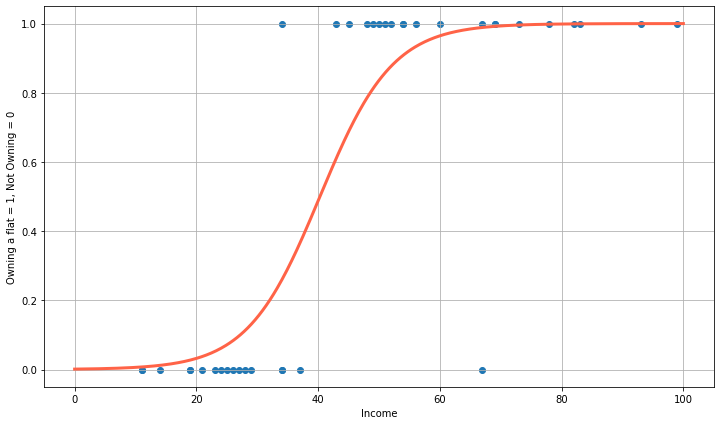

In [119]:
X = np.linspace(0, 100, 500)
P_hat = 1/(1 + np.exp(-log_reg.params[0]-log_reg.params[1]*X))

fig, ax = plt.subplots(figsize = (12, 7))
ax.scatter(df['Annual_Family_Income'], df['Own_House'])
ax.plot(X, P_hat, color = 'tomato', lw = 3)
ax.grid()
ax.set_xlabel('Income')
ax.set_ylabel('Owning a flat = 1, Not Owning = 0')
plt.show()

To interpret estimated coefficients, we can calculate the marginal effect by taking derivative w.r.t certain $\beta$, in this case $\beta_1$.
$$
\frac{dP_i}{d X_i} = \frac{dP_i}{dZ_i}\frac{dZ_i}{dX_i}=\frac{e^{-Z_i}}{(1+e^{-Z_i})^2}\beta_2
$$
Plot both accumulative and marginal effects

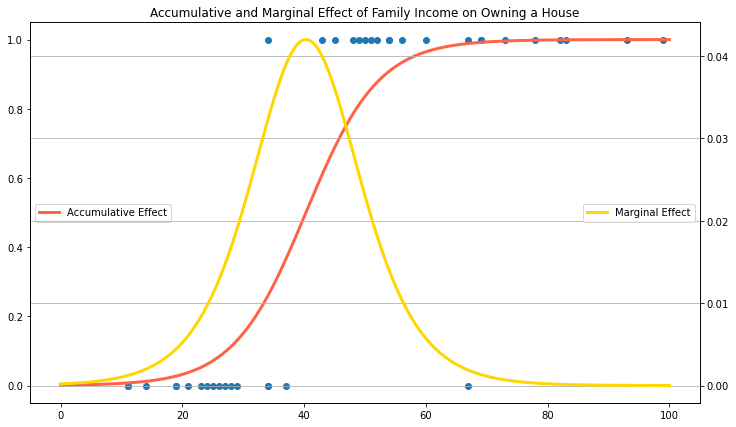

In [121]:
beta1_hat, beta2_hat = log_reg.params[0], log_reg.params[1]
X = np.linspace(0, 100, 500)

Z = beta1_hat + beta2_hat*X
dPdX = np.exp(-Z)/(1+np.exp(-Z))**2*beta2_hat

fig, ax1 = plt.subplots(figsize = (12, 7))
ax1.scatter(df['Annual_Family_Income'], df['Own_House'])
ax1.plot(X, P_hat, color = 'tomato', lw = 3, label='Accumulative Effect')
ax1.legend(loc ='center left')

ax2 = ax1.twinx() 
ax2.plot(X, dPdX, lw = 3, color = 'Gold', label = 'Marginal Effect')
ax2.legend(loc='center right')
ax2.set_title('Accumulative and Marginal Effect of Family Income on Owning a House')
ax2.grid()
plt.show()

As family income raises, the marginal probability will reach maximum around $40000$ pounds, to summarize the effect, we calculate the marginal effect at the mean value of the independent variables. 

In [107]:
X_mean = np.mean(df['Annual_Family_Income'])
Z_mean_effect = beta1_hat + beta2_hat*X_mean
dPdX = np.exp(-Z_mean_effect)/(1+np.exp(-Z_mean_effect))**2*beta2_hat; dPdX

0.03297676614392626

At the sample mean, $1000$ pounds increase in family income increases the probability of owning a house by $3.2 \%$. 

## <font face="gotham" color="purple"> More Than One Variable</font>

In [138]:
df = pd.read_excel('Basic_Econometrics_practice_data.xlsx', sheet_name = 'GMAT_Work_Quali_Resp'); df.head()

Y = df[['admitted']]
X = df[['gmat', 'gpa', 'work_experience']]
X = sm.add_constant(X)
log_reg_house = sm.Logit(Y, X).fit()
print(log_reg_house.summary())

Optimization terminated successfully.
         Current function value: 0.247296
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               admitted   No. Observations:                   30
Model:                          Logit   Df Residuals:                       26
Method:                           MLE   Df Model:                            3
Date:                Thu, 09 Sep 2021   Pseudo R-squ.:                  0.6432
Time:                        12:16:41   Log-Likelihood:                -7.4189
converged:                       True   LL-Null:                       -20.794
Covariance Type:            nonrobust   LLR p-value:                 6.639e-06
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -16.3315      8.601     -1.899      0.058     -33.189       0.526
gmat          

The estimated model is
$$
\hat{P_i} = \frac{1}{1+e^{-(-16.3315+0.0025 X_{2i} + 3.3208 X_{3i}+.9975 X_{4i})}}
$$


In [124]:
log_reg.params

const             -16.331480
gmat                0.002504
gpa                 3.320769
work_experience     0.997466
dtype: float64

In [131]:
beta1_hat, beta2_hat, beta3_hat, beta4_hat = log_reg.params[0], log_reg.params[1], log_reg.params[2], log_reg.params[3]
X2_mean = np.mean(df['gmat'])
X3_mean = np.mean(df['gpa'])
X4_mean = np.mean(df['work_experience'])
Z_mean_effect = beta1_hat + beta2_hat*X2_mean + + beta3_hat*X3_mean + beta4_hat*X4_mean
dPdX2 = np.exp(-Z_mean_effect)/(1+np.exp(-Z_mean_effect))**2*beta2_hat
dPdX3 = np.exp(-Z_mean_effect)/(1+np.exp(-Z_mean_effect))**2*beta3_hat
dPdX4 = np.exp(-Z_mean_effect)/(1+np.exp(-Z_mean_effect))**2*beta4_hat
print('Marginal effect of GMAT, GPA and Working Exp are {}, {} and {} accordingly.'.format(dPdX2, dPdX3, dPdX4))

Marginal effect of GMAT, GPA and Working Exp are 0.0005751109753324387, 0.7627645112662916 and 0.22911309163038573 accordingly.


## <font face="gotham" color="purple"> Goodness of Fit</font>

You might be wondering why log-likelihood is a negative number as in the report, recall that any likelihood is a joint distribution which must lie between $[0, 1]$, so the log likelihood must be negative, the plot below is a reminder.

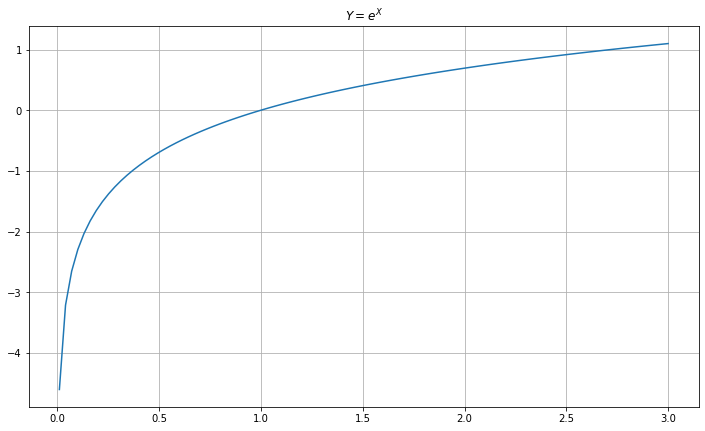

In [137]:
X = np.linspace(0.01, 3, 100)
Y = np.log(X)
fig, ax = plt.subplots(figsize = (12, 7))
ax.plot(X, Y)
ax.grid()
ax.set_title('$Y = e^X$')
plt.show()

Because the estimation method is MLE, which means we are not seeking to minimize $RSS$, then it would be meaningless to report $R^2$. So the proper replacement is pseudo-$R^2$ as in report.

Pseudo-$R^2$ is comparing the log-likelihood $\ln{L}$ of the original model with log-likelihood $\ln{L_0}$ that would have been obtained with only the intercept in the regression.
$$
\text{pseudo-}R^2=1-\frac{\ln{L}}{\ln{L_0}}
$$
Compare with $R^2$ in OLS, conceptually, $\ln{L}$ is equivalent to $RSS$ and $\ln{L_0}$ is equivalent to $TSS$ of the linear regression model.
$$
R^2 =1-\frac{RSS}{TSS}
$$

The results object has those data encapsulated, we just call the properties

In [147]:
Pseudo_R2 = 1- log_reg_house.llf/log_reg_house.llnull
print('Pseudo-R2: {}'.format(Pseudo_R2))

Pseudo-R2: 0.6432266516492773


The equivalent $F$-test in linear regression model is **likelihood ratio** (LR)
$$
2\ln{(L/L_0)} = 2(\ln{L}-\ln{L_0})
$$
which follows $\chi^2$ with $k-1$ degree of freedom, $k-1$ is the number of independent variables.

In [146]:
LR = 2*(log_reg_house.llf-log_reg_house.llnull)
print('Likelihood Ratio: {}'.format(LR))

Likelihood Ratio: 26.75104440310262


Keep in mind, with qualitative response models, goodness of fit is not a main concern. 

# <font face="gotham" color="purple"> The Probit Model</font>

# <font face="gotham" color="purple"> Logit VS Probit</font>

Since they yield similar results, which one is preferable? In practice, more researchers choose Logit due its mathematical simplicity. 